In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, random
import math


In [2]:
%matplotlib inline 

In [3]:
def fetch_random_img(dirpath=r'MNIST\trainingSample'):
    files = os.listdir(dirpath)
    idx=random.randrange(0, len(files))
    img=np.array(Image.open(os.path.join(dirpath, files[idx])))
    return img

In [4]:
def show_random_images(row=5,col=5,dirpath=r'MNIST\trainingSample'):
    fig,axs=plt.subplots(row,col)
    for i in range(row):
        for j in range(col):
            axs[i,j].imshow((fetch_random_img(dirpath=dirpath)))

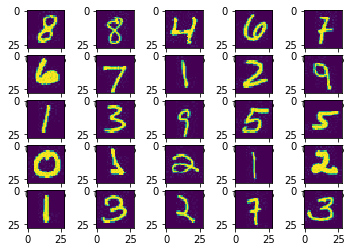

In [5]:
show_random_images()

In [6]:
def pad_img(X,pad_size_w=2,pad_size_h=2):
    """
    X is a batch of n images each with w*h*c dimension 
    where w,h and c are width,height and number of channels of each input image
    """ 
    X_paded=np.pad(X,mode='constant',constant_values=(0,0),pad_width=((0,0),(pad_size_w,pad_size_w),(pad_size_h,pad_size_h),(0,0)))
    return X_paded

### Test pad_img() function 

(1, 28, 28, 1)
(1, 32, 32, 1)


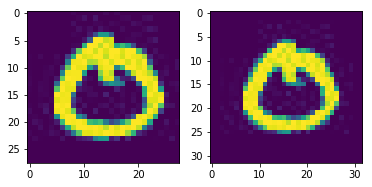

In [7]:
img=fetch_random_img()
img=np.expand_dims(img, axis=0) # add the dimension related to batch
img=np.expand_dims(img, axis=3) # add the dimension related to number of channels

print(img.shape)
padded_img=pad_img(img)
print(padded_img.shape)

fig,axs=plt.subplots(1,2)
axs[0].imshow(img[0,:,:,0])
axs[1].imshow(padded_img[0,:,:,0])

### Convolution Layer
The snapshot below (taken from http://cs231n.github.io/convolutional-networks/) could show the convolution procedure

<td>
<img src="images\CNN_conv.png">
<td>

In [8]:
def RELU(a):
    return max(a,0)

In [9]:
def conv(X,filter,b,p,s,activation_func='RELU'):
    """
    X is a batch of n images each with X_w*X_h*X_c dimension 
    where X_w,X_h and X_c are width,height and number of channels of each input image.
    
    filter is the kernel used to convolve X. filter has a dimension of n_f*f_w*f_h*f_c 
    where n_f,f_w,f_h and f_c are number of filters,width, height and number of channels for each filter. 
    Please note that f_c would be equal to X_c.
    
    b is the bias which is a vector of dimension 1*f_c. It means that we will have one bias for each filter
    P is the pad size.
    s is the stride.
    activation_func could be 'RELU' or 'NONE'. 
    The dimension of convolved X  (i.e., the output of this function) would be:
    n*( (X_w - f_w + 2p)/s + 1 )*( (X_h - f_h + 2p)/s + 1 )*n_f
    
    """
    no_imgs=int(X.shape[0])
    n_f=int(filter.shape[0])
    padded_X=pad_img(X,pad_size_w=p,pad_size_h=p)
    print ("padded_X.shape=",padded_X.shape)
    f_w=int(filter.shape[1]) # width of filter
    f_h=int(filter.shape[2]) #height of filter
    
    O_w=int((padded_X.shape[1]-f_w+2*p)/s +1) # width of output
    O_h=int((padded_X.shape[2]-f_h+2*p)/s +1) #height of output


    convolved_X=np.zeros(shape=(no_imgs,O_w,O_h,n_f))
    
    for k in range(no_imgs): # for each image in the batch
        for f in range(n_f): # for each filter
            # calculate each cell of the convolved X
            for j in range(O_h):
                for i in range(O_w):
                    start_w=i*s #  identify the left corner start point of the current sliding window 
                    start_h=j*s #  identify the left corner start point of the current sliding window 
                    curr_input_slice=padded_X[k,start_w:start_w+f_w,start_h:start_h+f_h,:]
                    curr_filter=filter[f,:,:,:]
                    a=curr_input_slice*curr_filter
                    if activation_func=='RELU':
                        convolved_X[k,i,j,f]=RELU(np.sum(a)+b[f])
                    elif activation_func=='NONE':
                        convolved_X[k,i,j,f]=np.sum(a)+b[f]
    
    return convolved_X,X,s,p,filter # X,s,p  and filter are returned because we will need them in back propagation process (i.e.,to calculate derivative of cost function w.r.t X )
        
    

### Test conv() function

In [10]:
X=np.random.randint(5,size=(10,5,5,3))
filter=np.random.randint(5,size=(6,2,2,3))
bias=np.random.randint(100,size=(6))
print("bias=",bias)
conv_X,X,s,p,filter=conv(X,filter,bias,1,2,activation_func='RELU')
print ("X.shape=",X.shape,"filter.shape=",filter.shape,"conve_X.shape=",conv_X.shape)


bias= [11 57 85 76 99 45]
padded_X.shape= (10, 7, 7, 3)
X.shape= (10, 5, 5, 3) filter.shape= (6, 2, 2, 3) conve_X.shape= (10, 4, 4, 6)


### Pooling Layer

In [11]:
def pool(X,pool_size=(2,2),pool_type='MAX',s=1):
    """
    X is a batch of convoluted images with a dimension of n_x,w_x,h_x,c_x
    Pool_size defines the window size from which we are going to get the average or max. Pool_size has a dimension of p_w*p_h where
    p_w and p_h are width and height of the pooling window.
    s is stride
    pool_type will accept values 'MAX' and 'AVG'
    """
    O_w=int((X.shape[1]-pool_size[0])/s +1) # width of output
    O_h=int((X.shape[2]-pool_size[1])/s +1) #height of output
    n_x=int(X.shape[0])
    c_x=int(X.shape[3])
    pooled_X=np.zeros(shape=(n_x,O_w,O_h,c_x))
    
    for k in range(n_x): # for each image in the batch
        for c in range(c_x): # for each channel
            # calculate each cell of the pooled X
            for j in range(O_h):
                for i in range(O_w):
                    start_w=i*s #  identify the left corner start point of the current sliding window 
                    start_h=j*s #  identify the left corner start point of the current sliding window 
                    curr_input_slice=X[k,start_w:start_w+pool_size[0],start_h:start_h+pool_size[1],c]
                    if (pool_type=='MAX'):
                        pooled_X[k,i,j,c]=np.max(curr_input_slice)
                    elif (pool_type=='AVG'):
                        pooled_X[k,i,j,c]=np.avg(curr_input_slice)
    return pooled_X

    

### Test pool() function

In [12]:
X=np.random.randint(1000,size=(10,25,25,3))
pooled_X=pool(X,pool_size=(10,10),pool_type='MAX',s=3)
print ("X.shape=",X.shape,"pooled_X.shape=",pooled_X.shape)


X.shape= (10, 25, 25, 3) pooled_X.shape= (10, 6, 6, 3)


### Fully connected layer

In [13]:
def fc (X,no_of_fully_connected_nodes):
    """
    X is the input to the fully connected layer with a dimension of n_X*w_X*h_X*c_X
    where n_X, w_X, h_X and c_X are number of convolved images in the batch, width of each convolved image, height of 
    each convolved image and number of channels, respectively.
    The fully connected layer  would be of shape: n_X* no_of_fully_connected_nodes. 
    To do this conversion we would need "no_of_fully_connected_nodes" filters of dimension w_X*h_X*c_X
    """
    w_X=int(X.shape[1])
    h_X=int(X.shape[2])
    c_X=int(X.shape[3])
    filter=np.random.rand(no_of_fully_connected_nodes,w_X,h_X,c_X)
    bias=np.random.rand(no_of_fully_connected_nodes)
    FC,X,s,p,filter=conv(X,filter,bias,p=0,s=1,activation_func='RELU')
    return FC

### Test fully connected layer

In [14]:
X=np.random.randint(1000,size=(10,25,25,100))
fc1=fc(X,10) # should give us the output of shape (no_images=10, 1, 1, no_fully_connected_nodes=10)
fc2=fc(fc1,3) # should give us the output of shape (no_images=10, 1, 1, no_fully_connected_nodes=3)
print("fc1.shape=",fc1.shape)
print("fc2.shape=",fc2.shape)

padded_X.shape= (10, 25, 25, 100)
padded_X.shape= (10, 1, 1, 10)
fc1.shape= (10, 1, 1, 10)
fc2.shape= (10, 1, 1, 3)


### Softmax

In [15]:
def softmax(FC):
    return np.exp(FC)/np.sum(np.exp(FC))
    

### Test softmax() function

In [16]:
fc=np.random.rand(10)
print ("fc=",fc)
print("softmax(fc)=",softmax(fc))


fc= [0.2163496  0.98337819 0.24543417 0.47789179 0.372735   0.45032051
 0.54064281 0.98793871 0.03996347 0.62851839]
softmax(fc)= [0.07241484 0.1559351  0.07455193 0.09406194 0.08467299 0.09150396
 0.10015355 0.15664787 0.06070495 0.10935288]


### Define Loss function


In [17]:
def Loss(actual_v,estimated_v):
    return -1*(actual_v*np.log(estimated_v)+(1-actual_v)*np.log(1-estimated_v))

### Test Loss() function

In [18]:
print (Loss(np.random.rand(10),np.random.rand(10)))

[1.15044168 0.66505796 0.7067226  0.98863144 0.41180892 1.05516941
 0.57933055 0.47839752 1.00883735 1.85605229]


### Define Cost function

In [19]:
def Cost(actual_v,estimated_v):
    return np.average(Loss(actual_v,estimated_v))

### Test Cost() function

In [20]:
print (Cost(np.random.rand(10),np.random.rand(10)))

0.8104993625381566


### Backward propagation

 The snapshots below (i.e., taken from https://medium.com/@2017csm1006/forward-and-backpropagation-in-convolutional-neural-network-4dfa96d7b37e) show how to calculate gradients with respect to weights and inputs in the back propagation process:
<td>
<img src="images\bp1.jpeg">
<td>
<td>
<img src="images\bp2.png">
<td>
<td>
<img src="images\bp3.png">
<td>
<td>
<img src="images\bp4.jpeg">
<td>
<td>
<img src="images\bp5.png">
<td>
<td>
<img src="images\bp6.jpeg">
<td>
<td>
<img src="images\bp7.jpeg">
<td>

In [35]:
def bp_conv(d_out,X,stride,pad,filter):
    """
    d_out is the derivative of cost function wih respect to the output of current layer. Please note that 
    the output of current layer is the input of next layer. As a result, we could calculate d_out of each layer by 
    obtaining the derivative of cost function w.r.t the input of next layer.
    
    X is the input of the current layer
    s is the stride used for current layer
    p is is the padding used for current layer
    filter is the filter used for current layer
    
    This function returns:
    
    d_w which stands for the derivative of cost function w.r.t w parameters (i.e., each cell of each filter used 
    in current layer). d_w would be of shape n_f*f_w*f_h*f_c where n_f,f_w,f_h and f_c are number of filters,width,
    height and number of channels for each filter.
    
    d_b  which stands for the derivative of cost function w.r.t bias of each filter used in the current layer. d_b 
    would be of shape 1*f_c
    
    d_X  which stands for the derivative of cost function w.r.t input of this layer which will be used as the d_out of
    previous layer. d_X would be of shape n*w*h*c
    """
    # compute d_w
    
    d_out_no_channels=d_out.shape[3]
    bias=np.zeros(shape=(d_out_no_channels)) # a vector of zeros with length equal to the number of channels of d_out
    d_w,X,s,p,d_out=conv(X,d_out,bias,stride,pad,activation_func='NONE')
    print ("d_w=",d_w)
    print ("d_w.shape=",d_w.shape)
    # compute d_b
    
    # for each channel, since the derivative of output w.r.t the bias would be 1, 
    # the derivative of cost function w.r.t bias would be sum over all elements of partial derivatives of cost function 
    # w.r.t the output (i.e., sum over d_out elements)
    d_b=np.zeros(shape=(1,d_out_no_channels))
    for c in range(d_out_no_channels): 
        curr_channel=d_out[:,:,:,c]
        d_b[c]=np.sum(curr_channel)
    print ("d_b=",d_b)
    print ("d_b.shape=",d_b.shape)    
    # compute d_X
    
    # 1. rotae the filter matrix 180 degrees (https://grzegorzgwardys.wordpress.com/2016/04/22/8/)
    rotated_filter=np.zeros(shape=(filter.shape[0],filter.shape[1],filter.shape[2],filter.shape[3]))
    for f in range(filter.shape[0]):# each filter
        for c in range (filter.shape[3]): # each channel of each filter
            rotated_filter[f,:,:,c]=np.rot90(filter[f,:,:,c], 2)
    # 2. do padding on d_out in order to be able to perform full convolution 
    pad_size_w=rotated_filter.shape[1]-1
    pad_size_h=rotated_filter.shape[2]-1
    d_out_padded=pad_img(d_out,pad_size_w=pad_size_w,pad_size_h=pad_size_h)
    
    # 3. do the full convolution for each channel of each filter
    d_X,X,s,p=conv(d_out_padded,rotated_filter,b=bias,p=p,s=s,activation_func='NONE')
    return d_w,d_b,d_X

### Test bp_conv() function

In [42]:
X=np.random.randint(5,size=(1,5,5,3))
filter=np.random.randint(5,size=(7,2,2,3))
bias=np.random.randint(100,size=(7))
print("bias=",bias)
conv_X,X,s,p,filter=conv(X,filter,bias,1,2,activation_func='RELU')
print ("X.shape=",X.shape,"filter.shape=",filter.shape,"conve_X.shape=",conv_X.shape)

print("X=",X[0,:,:,0])
print("filter=",filter[0,:,:,0])
print("conv_X=",conv_X[0,:,:,0])

bias= [ 7 39 30 22 67 86 46]
padded_X.shape= (1, 7, 7, 3)
X.shape= (1, 5, 5, 3) filter.shape= (7, 2, 2, 3) conve_X.shape= (1, 4, 4, 7)
X= [[4 2 1 2 0]
 [1 2 2 4 4]
 [3 0 3 1 1]
 [0 4 2 0 0]
 [4 0 4 2 0]]
filter= [[3 2]
 [2 2]]
conv_X= [[19. 19. 13.  7.]
 [37. 56. 54.  7.]
 [29. 59. 41.  7.]
 [ 7.  7.  7.  7.]]


In [44]:
d_out=np.random.randint(5,size=(1,4,4,7))
d_w,d_b,d_X=bp_conv(d_out,X,0,1,filter=filter)
print (d_w.shape,d_b.shape,d_X.shape)

padded_X.shape= (1, 5, 5, 3)


ValueError: operands could not be broadcast together with shapes (4,4,3) (4,4,7) 